In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix
from scipy.stats import randint, uniform

In [2]:
train_df = pd.read_csv("../data/interim/twitter_train_processed.csv")
test_df  = pd.read_csv("../data/interim/twitter_test_processed.csv")

In [3]:
X_test_all = test_df.drop(columns=['account_type'])
y_test_all = test_df['account_type']

X_val, X_test, y_val, y_test = train_test_split(
    X_test_all, y_test_all, test_size=0.5, stratify=y_test_all, random_state=seed
)

In [4]:
X_train = train_df.drop(columns=['account_type'])
y_train = train_df['account_type']

# combine train + val for hyperparameter tuning
X_tune = pd.concat([X_train, X_val], axis=0)
y_tune = pd.concat([y_train, y_val], axis=0)

In [ ]:
def evaluate(model, X, y, label="Validation"):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    auc = roc_auc_score(y, y_prob)
    pr_auc = average_precision_score(y, y_prob)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print(f"\n{label} Set Metrics")
    print(f"AUC: {auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Confusion matrix
    disp = ConfusionMatrixDisplay.from_estimator(model, X, y, display_labels=["Human (0)", "Bot (1)"], cmap="Blues", colorbar=False)
    disp.ax_.set_title("Confusion Matrix")
    disp.ax_.set_xlabel("Predicted label")
    disp.ax_.set_ylabel("True label")
    plt.tight_layout()    
    plt.savefig(f"models/{label.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.close()

    # ROC curve
    fpr, tpr, _ = roc_curve(y, y_prob)
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.title(f"ROC Curve (AUC = {auc:.3f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.tight_layout()       
    plt.savefig(f"models/{label.lower().replace(' ', '_')}_roc_curve.png")
    plt.close()

    # Precision-Recall curve
    prec, rec, _ = precision_recall_curve(y, y_prob)
    plt.plot(rec, prec, label=f"Classifier (AP = {pr_auc:.3f})")
    plt.title(f"Precision-Recall Curve")
    plt.xlabel("Recall (Positive label: 1)")
    plt.ylabel("Precision (Positive label: 1)")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.savefig(f"models/{label.lower().replace(' ', '_')}_pr_curve.png")
    plt.close()    

    return auc, pr_auc, precision, recall, f1

In [7]:
search = RandomizedSearchCV(
        estimator=XGBClassifier(
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=seed,
            n_jobs=-1
        ),
        param_distributions={
            "n_estimators": randint(200, 800),
            "learning_rate": uniform(0.01, 0.3),
            "max_depth": randint(3, 7),
            "subsample": uniform(0.6, 0.4),
            "colsample_bytree": uniform(0.6, 0.4)
        },
        n_iter=25,
        scoring="roc_auc",
        n_jobs=-1,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed),
        verbose=1,
        random_state=seed
)

In [8]:
 # Tune on train + val
search.fit(X_tune, y_tune)
best_model = search.best_estimator_  

Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [00:01:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [9]:
print("\nBest hyperparameters:")
for param, value in search.best_params_.items():
    print(f"{param}: {value}")


Best hyperparameters:
colsample_bytree: 0.7797802696552814
learning_rate: 0.038623034947123394
max_depth: 5
n_estimators: 606
subsample: 0.8675365010654429


In [55]:
metrics = evaluate_model(best_model, X_test, y_test)


Validation Results for XGBClassifier
AUC: 0.937 | PR-AUC: 0.903
Precision: 0.856 | Recall: 0.771 | F1: 0.811
Sensitivity: 0.771 | Specificity: 0.936


In [12]:
xgb_model = best_model
explainer = shap.Explainer(xgb_model.predict_proba, X_test)
shap_values = explainer(X_test)

PermutationExplainer explainer: 3745it [08:11,  7.62it/s]                          



Top 10 global features:
                    feature  mean_abs_shap
5           followers_count       0.090431
0          favourites_count       0.088029
6             friends_count       0.047330
3          account_age_days       0.042104
1            statuses_count       0.038356
2    average_tweets_per_day       0.031214
14               verified_0       0.030589
12            geo_enabled_0       0.023888
7   followers_friends_ratio       0.023487
4        description_length       0.018680


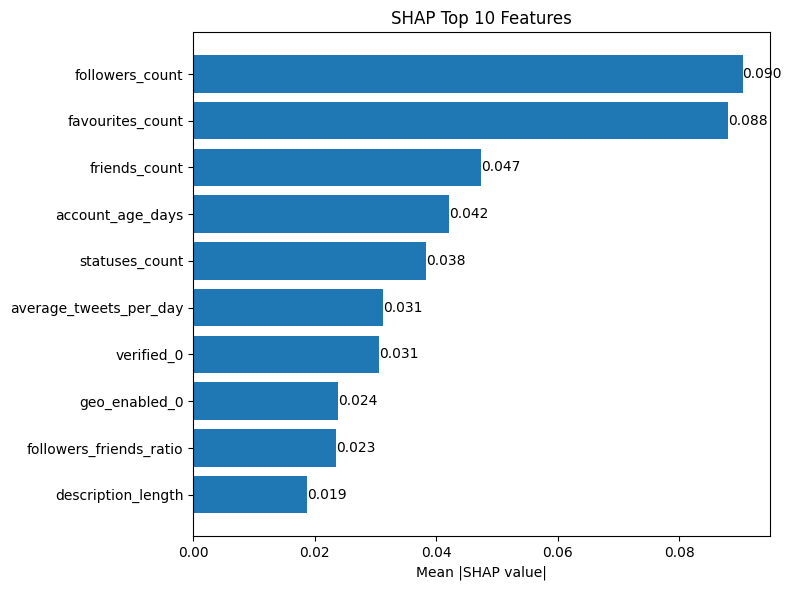

In [57]:
vals = np.asarray(shap_values.values)[:, :, 1]
global_importance = np.abs(vals).mean(axis=0)
shap_df = pd.DataFrame({"feature": X_test.columns, "mean_abs_shap": global_importance}).sort_values(by="mean_abs_shap", ascending=False)
top_features = shap_df.head(10)
print("\nTop 10 global features:")
print(top_features)

# Plot global features
plt.figure(figsize=(8, 6))
bars = plt.barh(top_features["feature"][::-1], top_features["mean_abs_shap"][::-1])
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1e-6, bar.get_y() + bar.get_height() / 2, f"{width:.3f}", va="center")
plt.xlabel("Mean |SHAP value|")
plt.title("SHAP Top 10 Features")
plt.tight_layout()
plt.show()


Top 10 features for bots:
                    feature  mean_abs_shap_subset
5           followers_count              0.131822
0          favourites_count              0.121354
6             friends_count              0.063479
1            statuses_count              0.057978
3          account_age_days              0.053910
2    average_tweets_per_day              0.036756
7   followers_friends_ratio              0.032195
12            geo_enabled_0              0.030316
14               verified_0              0.027437
4        description_length              0.023511


C:\Users\Admin\AppData\Local\Temp\ipykernel_31748\2101032978.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_subset, X_test_subset, plot_type="dot", max_display=10, show=False)


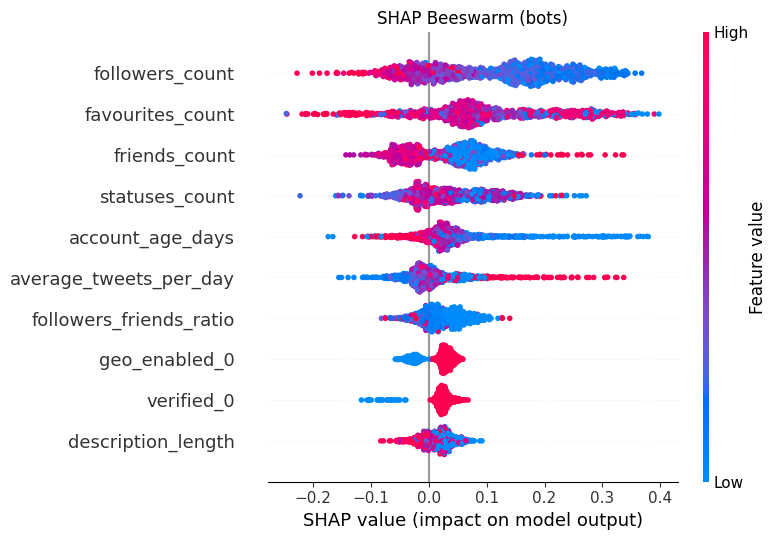

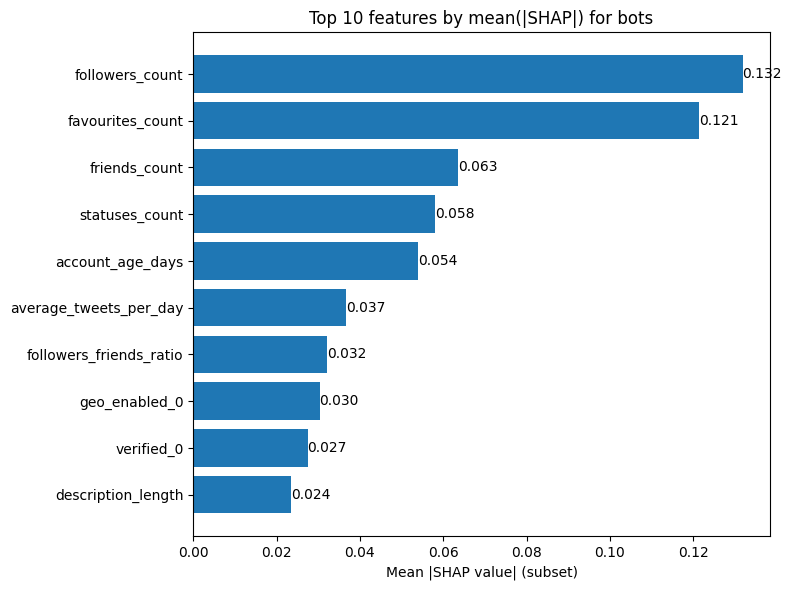

In [59]:
# Subset SHAP for bots
target = 1
y_test_arr = np.asarray(y_test).ravel()
mask = (y_test_arr == target)

# Extract class-specific SHAP
vals_local = np.asarray(shap_values.values)
shap_vals_subset = vals_local[mask, :, 1]
mean_abs_subset = np.abs(shap_vals_subset).mean(axis=0)
X_test_subset = X_test.iloc[mask].reset_index(drop=True)
feature_df_subset = pd.DataFrame({"feature": X_test.columns, "mean_abs_shap_subset": mean_abs_subset}).sort_values("mean_abs_shap_subset", ascending=False)
top_subset = feature_df_subset.head(10)
print("\nTop 10 features for bots:")
print(top_subset)

# Beeswarm
plt.figure(figsize=(9, 6))
shap.summary_plot(shap_vals_subset, X_test_subset, plot_type="dot", max_display=10, show=False)
plt.title(f"SHAP Beeswarm (bots)")
plt.tight_layout()
plt.show()

# Bar plot
plt.figure(figsize=(8, 6))
bars = plt.barh(top_subset["feature"][::-1], top_subset["mean_abs_shap_subset"][::-1])
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1e-6, bar.get_y() + bar.get_height() / 2, f"{width:.3f}", va="center")
plt.xlabel("Mean |SHAP value| (subset)")
plt.title(f"Top 10 features by mean(|SHAP|) for bots")
plt.tight_layout()
plt.show()

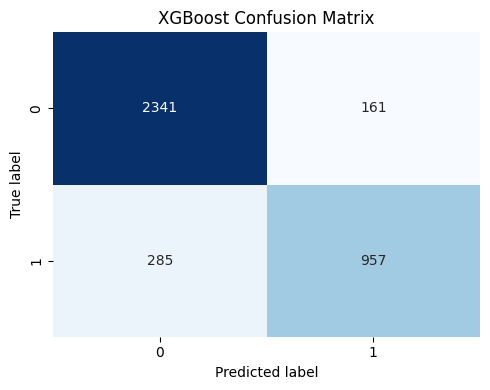

In [60]:
# Confusion matrix
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


Top 10 global features:
                    feature  mean_abs_shap
5           followers_count       0.090431
0          favourites_count       0.088029
6             friends_count       0.047330
3          account_age_days       0.042104
1            statuses_count       0.038356
2    average_tweets_per_day       0.031214
14               verified_0       0.030589
12            geo_enabled_0       0.023888
7   followers_friends_ratio       0.023487
4        description_length       0.018680


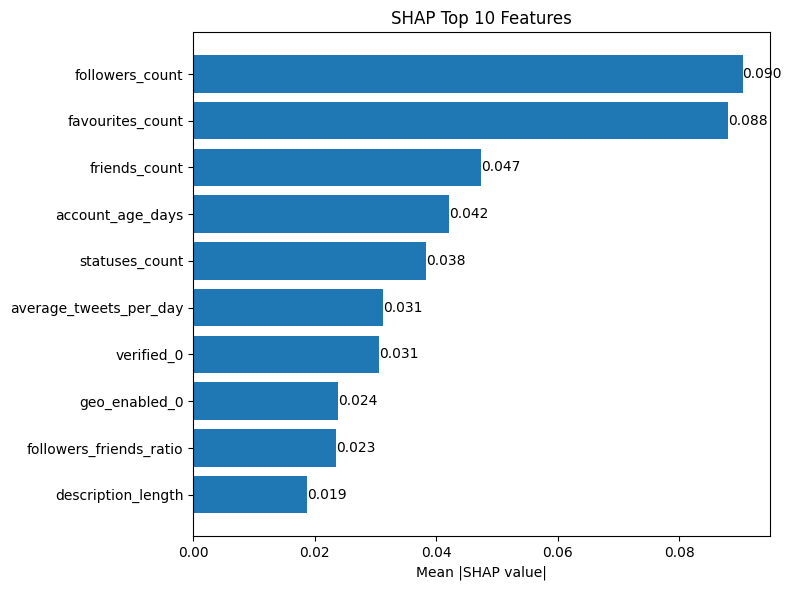

In [35]:
vals = np.asarray(shap_values.values)[:, :, 1]
global_importance = np.abs(vals).mean(axis=0)
shap_df = pd.DataFrame({"feature": X_test.columns, "mean_abs_shap": global_importance}).sort_values(by="mean_abs_shap", ascending=False)
top_features = shap_df.head(10)
print("\nTop 10 global features:")
print(top_features)

plt.figure(figsize=(8, 6))
bars = plt.barh(top_features["feature"][::-1], top_features["mean_abs_shap"][::-1])
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1e-6, bar.get_y() + bar.get_height() / 2, f"{width:.3f}", va="center")
plt.xlabel("Mean |SHAP value|")
plt.title("SHAP Top 10 Features")
plt.tight_layout()
plt.show()

In [ ]:
target = 1
y_test_arr = np.asarray(y_test).ravel()
mask = (y_test_arr == target)

# Extract class-specific SHAP
vals_local = np.asarray(shap_values)
shap_vals_subset = vals_local[mask, :]
X_test_subset = X_test.iloc[mask].reset_index(drop=True)

TypeError: bad operand type for abs(): 'Explanation'


Top 10 features for bots:
                    feature  mean_abs_shap_subset
5           followers_count              0.131822
0          favourites_count              0.121354
6             friends_count              0.063479
1            statuses_count              0.057978
3          account_age_days              0.053910
2    average_tweets_per_day              0.036756
7   followers_friends_ratio              0.032195
12            geo_enabled_0              0.030316
14               verified_0              0.027437
4        description_length              0.023511


C:\Users\Admin\AppData\Local\Temp\ipykernel_31748\4148528246.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_subset, X_test_subset, plot_type="dot", max_display=10, show=False)


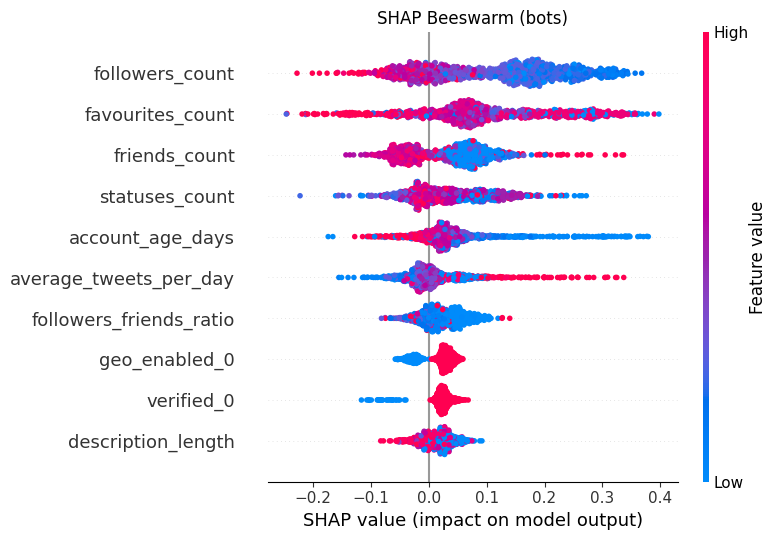

In [51]:
vals_local = np.asarray(shap_values.values)
shap_vals_subset = vals_local[mask, :, 1]
mean_abs_subset = np.abs(shap_vals_subset).mean(axis=0)
X_test_subset = X_test.iloc[mask].reset_index(drop=True)
feature_df_subset = pd.DataFrame({"feature": X_test.columns, "mean_abs_shap_subset": mean_abs_subset}).sort_values("mean_abs_shap_subset", ascending=False)
top_subset = feature_df_subset.head(10)
print("\nTop 10 features for bots:")
print(top_subset)

# Beeswarm
plt.figure(figsize=(9, 6))
shap.summary_plot(shap_vals_subset, X_test_subset, plot_type="dot", max_display=10, show=False)
plt.title(f"SHAP Beeswarm (bots)")
plt.tight_layout()
plt.show()

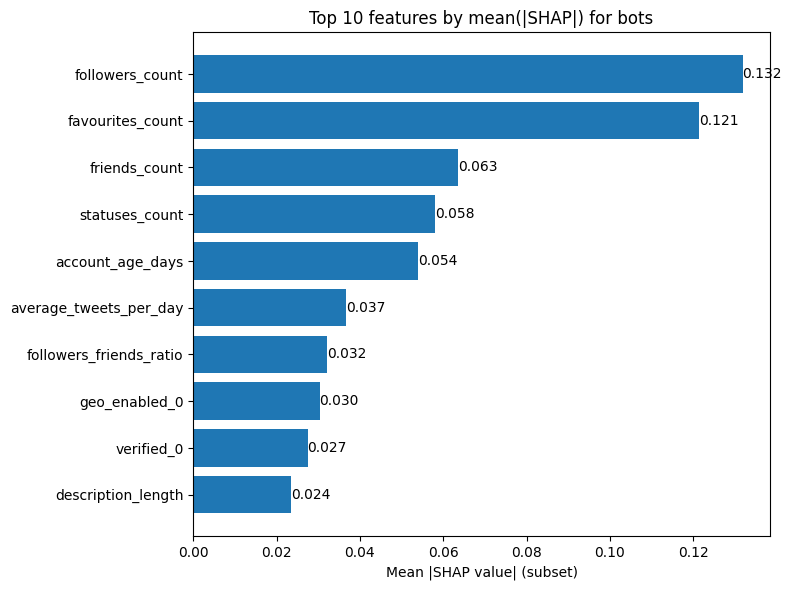

In [52]:
plt.figure(figsize=(8, 6))
bars = plt.barh(top_subset["feature"][::-1], top_subset["mean_abs_shap_subset"][::-1])
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1e-6, bar.get_y() + bar.get_height() / 2, f"{width:.3f}", va="center")
plt.xlabel("Mean |SHAP value| (subset)")
plt.title(f"Top 10 features by mean(|SHAP|) for bots")
plt.tight_layout()
plt.show()